# Mathematical Foundations of Computer Graphics and Vision 2022
## Exercise 5 - RIGID TRANSFORM BLENDING AND VARIATIONAL METHODS
## PART 2: Variational Methods - Denoising problems

In [1]:
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from tqdm import tqdm

In [2]:
def compute_errors(original, images):
    errors = [np.abs(original - image).mean() for image in images]
    relative_errors = [(error / errors[0]) for error in errors]
    return relative_errors

def plot_conv_res(I_orig, I_n):
    f = plt.figure(figsize=(20,6))
    ax1 = f.add_subplot(131)
    ax2 = f.add_subplot(132)
    ax3 = f.add_subplot(133)
    ax1.title.set_text('Original Image')
    ax2.title.set_text('Noisy Image')
    ax3.title.set_text('Dummy error visualization')
    ax1.imshow(I_orig, cmap='gray') 
    ax2.imshow((np.clip(I_n*255.0, 0, 255)).astype(np.uint8), cmap='gray') 
    ratios = np.linspace(0, 1, 10)
    errors = compute_errors(I_orig, [(1 - r) * I_n + r * I_orig for r in ratios])
    ax3.plot(ratios, errors)

In [3]:
I_orig_img = Image.open('lotr.jpg')
I_orig_img = I_orig_img.convert('L')
I_orig = np.array(I_orig_img)/255.0
h, w = np.shape(I_orig)

In [4]:
# Add noise
gauss = np.random.normal(0, 0.22, (h, w))
gauss = gauss.reshape(h, w)
I_n = I_orig + gauss
# Visualize
# I_orig_img.show()
# Image.fromarray((np.clip(I_n*255.0, 0, 255)).astype(np.uint8)).show()

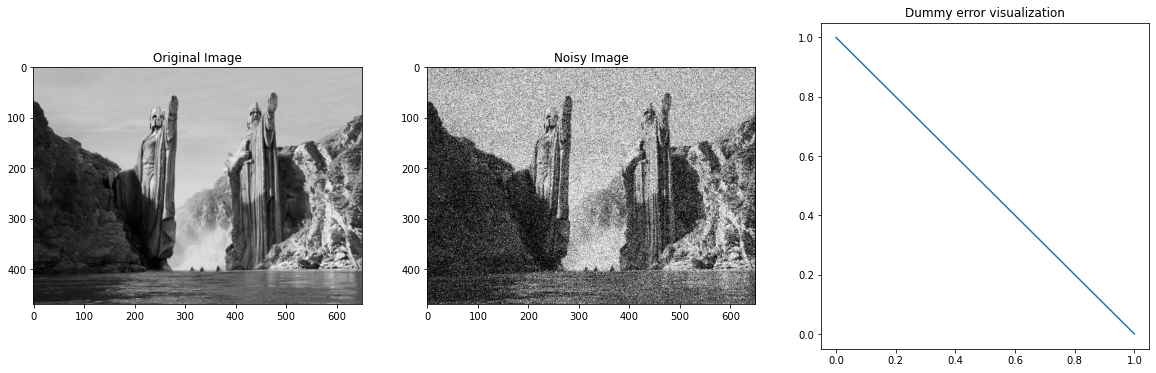

In [5]:
plot_conv_res(I_orig, I_n)

### 2.1. Task 1 - Filtering

In [6]:
def get_gaussian_filter(shape=(5, 5),sigma=0.5):
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def gaussian_filtering(I_orig, I_n, n_iter = 32, sigma = 0.5, boundary = 'Dirichlet'):
    filter_size = 2 * math.ceil(3 * sigma) + 1
    I_filter = I_n.copy()
    g = get_gaussian_filter(shape = (filter_size, filter_size), sigma = sigma)
    fig, axs = plt.subplots(int(n_iter / 16), 2, figsize=(15,10))
    fig.suptitle("Denoised image after filtering multiple time", fontsize="x-large")
    images = []
    images.append(I_filter.copy())
    for i in tqdm(range(n_iter)):
        if boundary == 'Dirichlet':
            I_filter = signal.convolve2d(I_filter, g, boundary='symm', mode = 'same')
        elif boundary == 'Neuman':
            I_filter = signal.convolve2d(I_filter, g, boundary='fill', mode = 'same', fillvalue = 0)
        images.append(I_filter.copy())
        if (i + 1)%8 == 0:
            axs[int(i/16), int(i/8)%2].imshow((np.clip(I_filter*255.0, 0, 255)).astype(np.uint8), cmap='gray')
            axs[int(i/16), int(i/8)%2].set_title("Filtered {} times".format(i + 1))
    errors = compute_errors(I_orig, images)
    return images, I_filter, errors

100%|██████████| 32/32 [00:02<00:00, 14.06it/s]


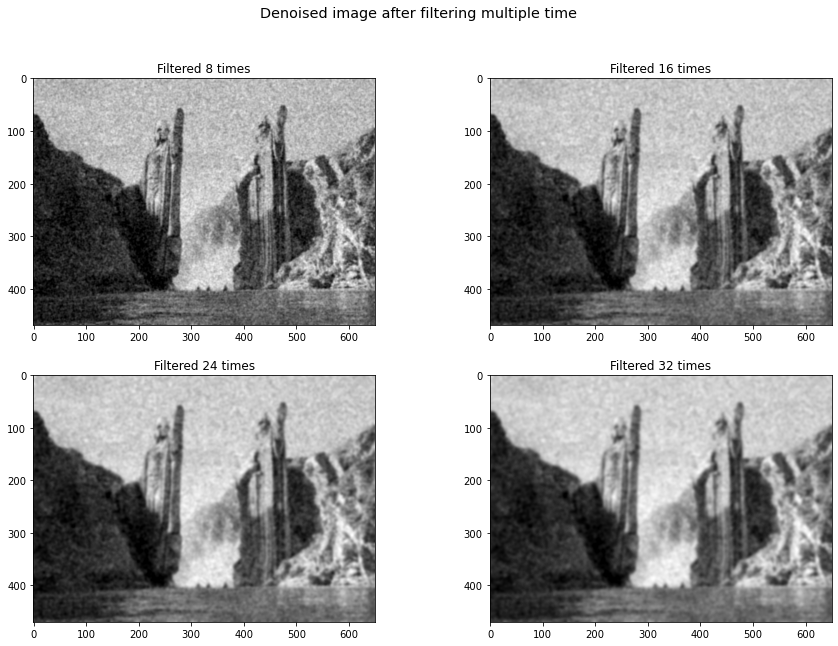

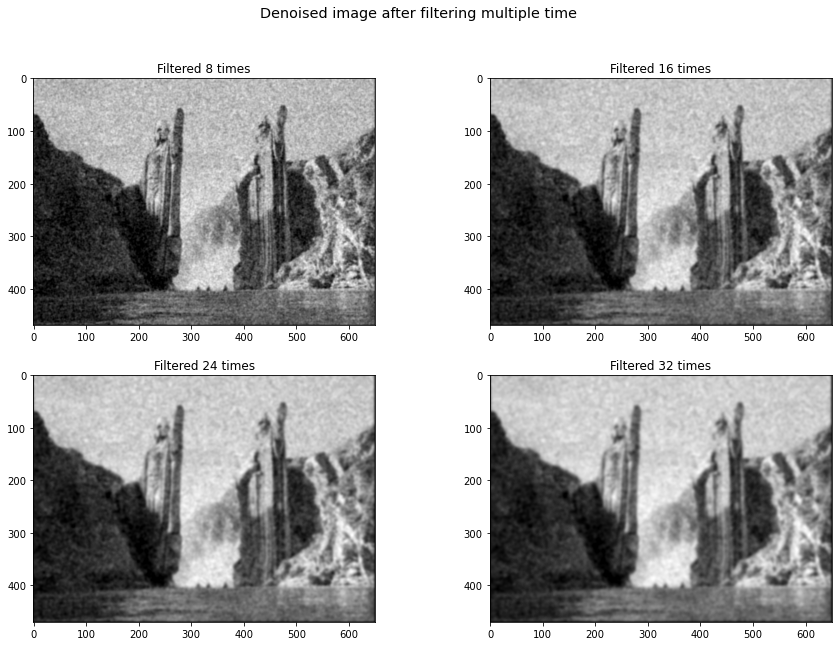

In [7]:
images_gaussian, _, errors_D = gaussian_filtering(I_orig, I_n, n_iter = 32, sigma = 0.5)
_, _, errors_N = gaussian_filtering(I_orig, I_n, n_iter = 32, sigma = 0.5, boundary = 'Neuman')

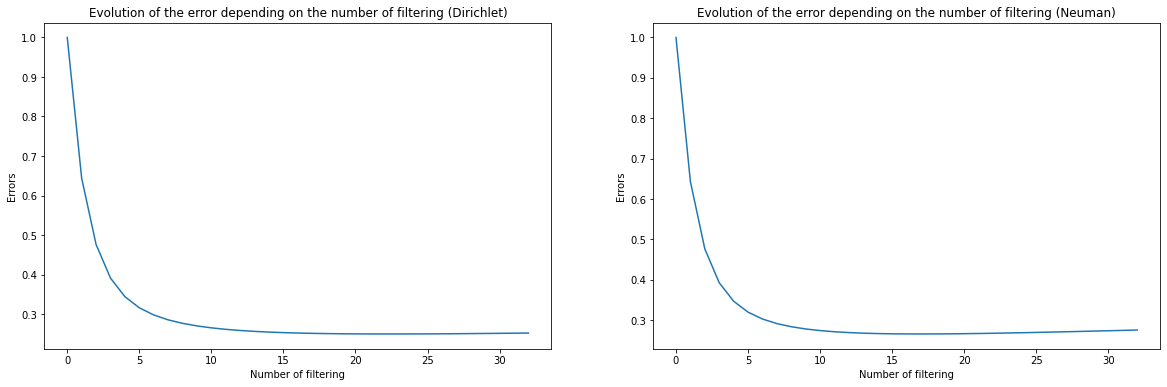

In [8]:
f = plt.figure(figsize=(20,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.set_xlabel('Number of filtering')
ax1.set_ylabel('Errors')
ax1.set_title('Evolution of the error depending on the number of filtering (Dirichlet)')
ax2.set_xlabel('Number of filtering')
ax2.set_ylabel('Errors')
ax2.set_title('Evolution of the error depending on the number of filtering (Neuman)')
ax1.plot(np.arange(0, len(errors_D), 1),errors_D)
ax2.plot(np.arange(0, len(errors_N), 1),errors_N)

In [9]:
gaussian_best_iter = np.argmin(errors_D)
gaussian_best = images_gaussian[gaussian_best_iter]

### 2.2. Task 2 - Heat diffusion

In [10]:
def get_laplacian_filter():
    H = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    return H

def heat_diffusion(I_orig, I_n, n_iter = 100, tau = 0.1, boundary = 'Dirichlet'):
    I_filter = I_n.copy()
    g = get_laplacian_filter()
    fig, axs = plt.subplots(int(n_iter / 50), 2, figsize=(15,10))
    fig.suptitle("Denoised image after difusion", fontsize="x-large")
    images = []
    images.append(I_filter.copy())
    for i in tqdm(range(n_iter)):
        if boundary == 'Dirichlet':
            LI =  signal.convolve2d(I_filter, g, boundary='symm', mode = 'same')
        elif boundary == 'Neuman':
            LI =  signal.convolve2d(I_filter, g, boundary='fill', mode = 'same', fillvalue = 0)
        I_filter = I_filter +  LI * tau
        images.append(I_filter.copy())
        if (i + 1)%25 == 0:
            axs[int(i/50), int(i/25)%2].imshow((np.clip(I_filter*255.0, 0, 255)).astype(np.uint8), cmap='gray')
            axs[int(i/50), int(i/25)%2].set_title("Diffusion at time {}".format(i + 1))
    errors = compute_errors(I_orig, images)
    return images, I_filter, errors

100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


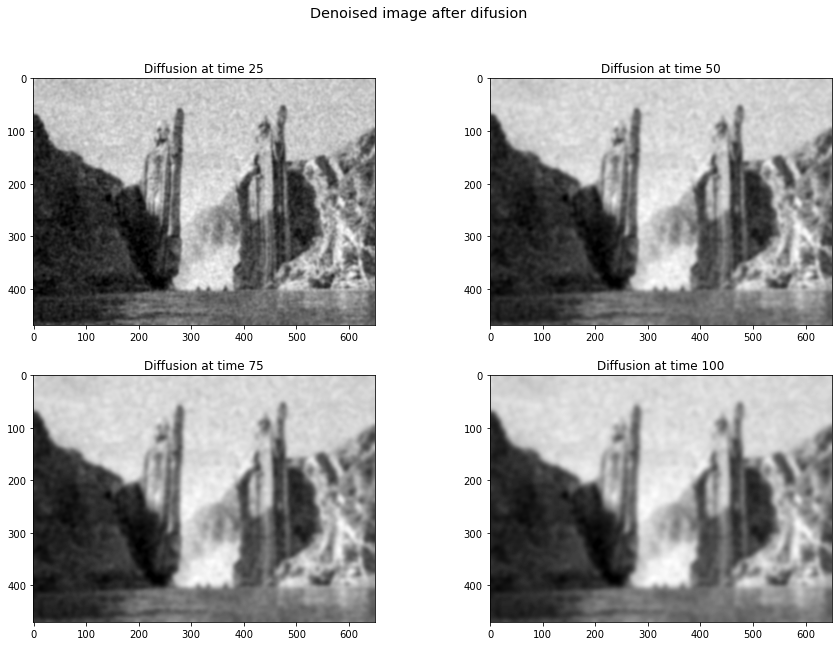

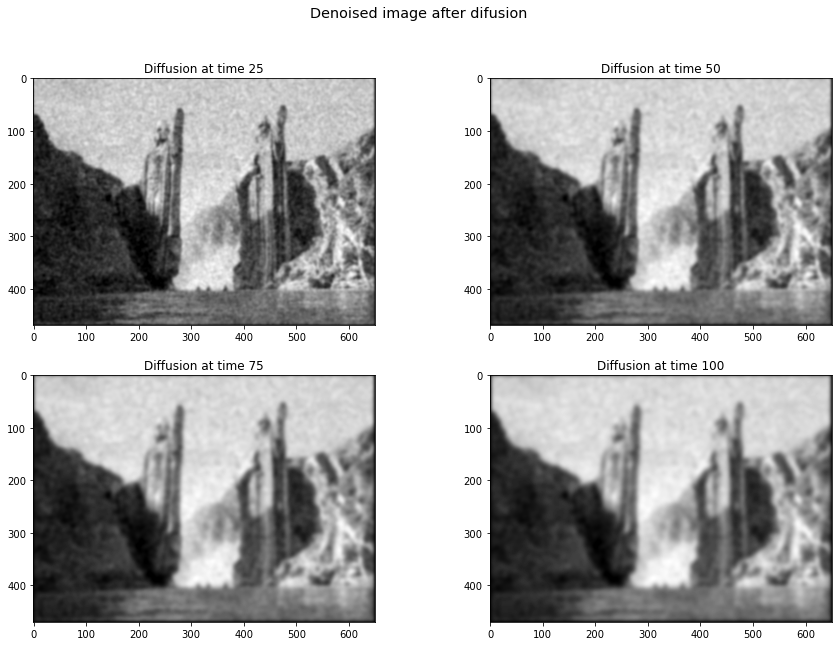

In [11]:
images_laplacian, _, errors_D = heat_diffusion(I_orig, I_n, n_iter = 100, tau = 0.1)
_, _, errors_N = heat_diffusion(I_orig, I_n, n_iter = 100, tau = 0.1, boundary = 'Neuman')

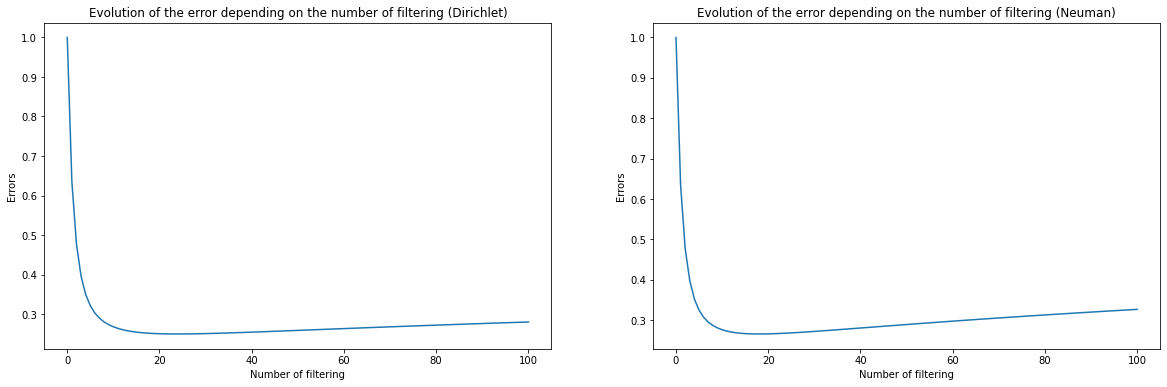

In [12]:
f = plt.figure(figsize=(20,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.set_xlabel('Number of filtering')
ax1.set_ylabel('Errors')
ax1.set_title('Evolution of the error depending on the number of filtering (Dirichlet)')
ax2.set_xlabel('Number of filtering')
ax2.set_ylabel('Errors')
ax2.set_title('Evolution of the error depending on the number of filtering (Neuman)')
ax1.plot(np.arange(0, len(errors_D), 1),errors_D)
ax2.plot(np.arange(0, len(errors_N), 1),errors_N)

In [13]:
laplacian_best_iter = np.argmin(errors_D) 
laplacian_best = images_laplacian[np.argmin(errors_D)]

### 2.3. Task 3 - Variational approach
* The derivation of Euler-Lagrange equation is in the report

In [14]:
def variation(I_n, lmbda = 2):
    I_filter = I_n.copy().reshape(I_n.shape[0] * I_n.shape[1], -1)
    N = I_filter.shape[0]
    w = I_n.shape[1]
    A = csc_matrix( ( (1 + 4 * lmbda)*np.ones(N), ( np.arange(0, N, 1), np.arange(0, N, 1) ) ), shape = (N, N))
    A += csc_matrix( ( -lmbda*np.ones(N - 1), ( np.arange(0, N-1, 1), np.arange(1, N, 1) ) ), shape = (N, N))
    A += csc_matrix( ( -lmbda*np.ones(N - 1), ( np.arange(1, N, 1), np.arange(0, N-1, 1) ) ), shape = (N, N))
    A += csc_matrix( ( -lmbda*np.ones(N - w), ( np.arange(0, N-w, 1), np.arange(w, N, 1) ) ), shape = (N, N))
    A += csc_matrix( ( -lmbda*np.ones(N - w), ( np.arange(w, N, 1), np.arange(0, N-w, 1) ) ), shape = (N, N))
    I_filter = spsolve(A, I_filter)
    return I_filter.reshape(I_n.shape)

In [15]:
I_var = variation(I_n)

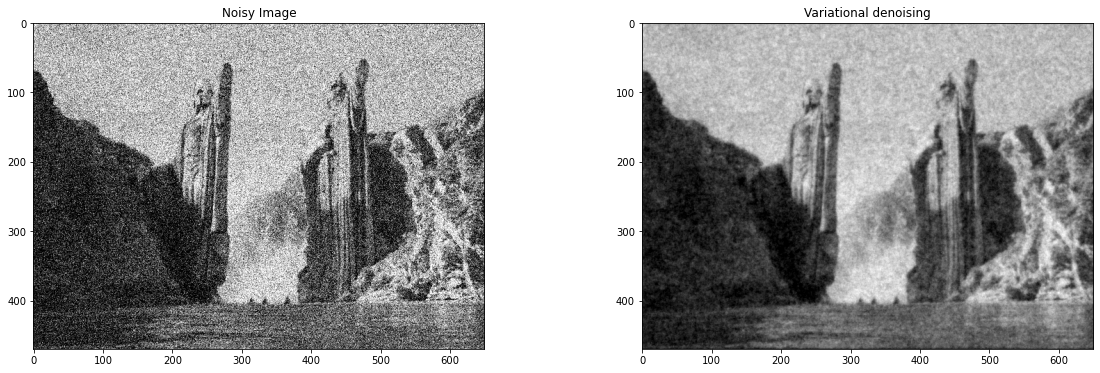

In [16]:
f = plt.figure(figsize=(20,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.title.set_text('Noisy Image')
ax2.title.set_text('Variational denoising')
ax1.imshow((np.clip(I_n*255.0, 0, 255)).astype(np.uint8), cmap='gray') 
ax2.imshow((np.clip(I_var*255.0, 0, 255)).astype(np.uint8), cmap='gray') 

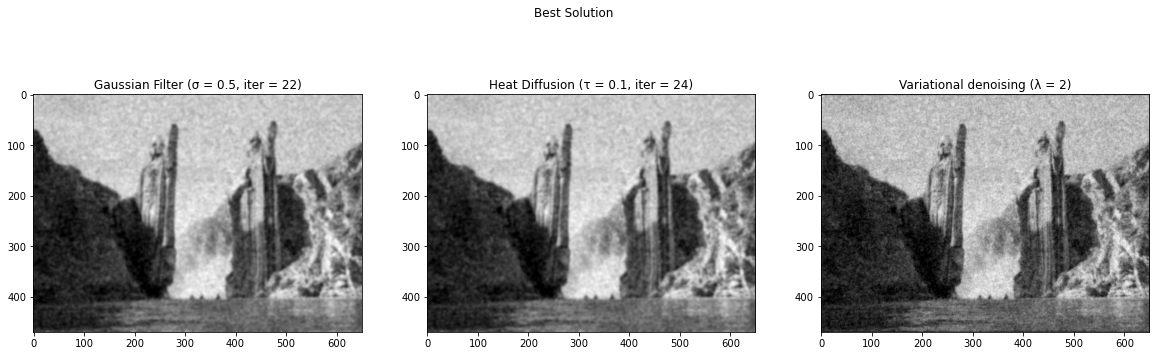

In [17]:
f = plt.figure(figsize=(20,6))
f.suptitle('Best Solution')
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
ax1.title.set_text('Gaussian Filter (σ = 0.5, iter = {})'.format(gaussian_best_iter))
ax2.title.set_text('Heat Diffusion (τ = 0.1, iter = {})'.format(laplacian_best_iter))
ax3.title.set_text('Variational denoising (λ = 2)')
ax1.imshow((np.clip(gaussian_best*255.0, 0, 255)).astype(np.uint8), cmap='gray') 
ax2.imshow((np.clip(laplacian_best*255.0, 0, 255)).astype(np.uint8), cmap='gray') 
ax3.imshow((np.clip(I_var*255.0, 0, 255)).astype(np.uint8), cmap='gray') 